<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/Basic_Skills/02_Dataset_and_Dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset / Dataloader

PyTorch에서는 Data를 처리하여 model에 공급하는 방법으로 Dataset과 Dataloader를 제공한다.

Dataset은 data와 label을 저장하고, DataLoader는 Dataset을 model에 공급할 수 있도록 iterable 객체로 감싸주는 역할을 한다.

### PyTorch import

In [ ]:
import torch
print(torch.__version__)

In [ ]:
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

### FashionMNIST data 불러오기

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as tr

In [ ]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=tr.ToTensor() # 0~1 scaling도 포함
)

testing_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=tr.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### 데이터 시각화 하기

In [ ]:
print(training_data)
print()
print(f'label of image sample: {training_data[0][1]}')

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

label of image sample: 9


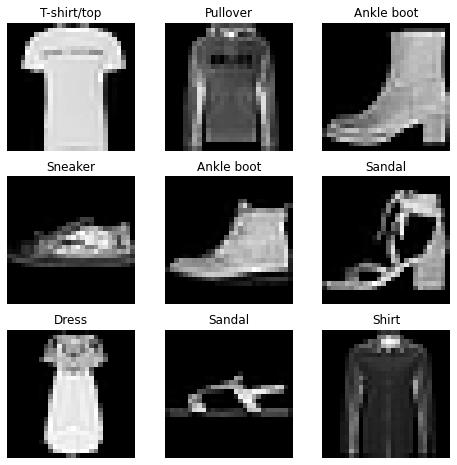

In [ ]:
labels_map = {
    0:	'T-shirt/top',
    1:	'Trouser',
    2:	'Pullover',
    3:	'Dress',
    4:	'Coat',
    5:	'Sandal',
    6:	'Shirt',
    7:	'Sneaker',
    8:	'Bag',
    9:	'Ankle boot'
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### DataLoader 만들기

In [ ]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False) # test 데이터는 shuffle 불필요

In [ ]:
# DataLoader 통해 반복하기(iterate)
train_features, train_labels = next(iter(train_dataloader)) # iter: iterable to iteraator / next: iterator에서 한 칸씩 전진
print(f'Features batch shape: {train_features.size()}') # tensor.size() == tensor.shape
print(f'Labels batch shape: {train_labels.size()}')

Features batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


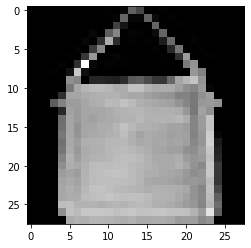

Label: 8


In [ ]:
img = train_features[0].squeeze() # 맨 앞 채널(1) 없애주어야 함
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

## Model

In [ ]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current device: {device}')

Current device: cuda


### Model Class 만들기

In [ ]:
class MyModel(nn.Module): # torch.nn.Module 상속
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10) # loss 계산 시 softmax 처리
    )
  
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
# Model instance 생성, device 설정
model = MyModel().to(device)
print(model)

MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# 가상의 데이터 만들어서 초기 모델으로 예측해보기
X = torch.randn(1, 28, 28, device=device)
logits = model(X)
pred_prob = nn.Softmax(dim=1)(logits) # class 별 확률
y_pred = pred_prob.argmax(1) # 최대 확률 class
print(f'pred_prob: {pred_prob}')
print(f'y_pred: {y_pred}')

pred_prob: tensor([[0.0853, 0.1029, 0.1435, 0.0992, 0.1082, 0.1395, 0.0840, 0.0906, 0.0807,
         0.0660]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
y_pred: tensor([2], device='cuda:0')


### Training / Validation

In [ ]:
# loss function / optimizer
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training을 위한 함수
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # pred와 loss 계산
    pred = model(X)
    loss = loss_fn(pred, y)

    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

# Testing을 위한 함수
def test_loop(dataloader, model, loss_fn): # optimizer X
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  
  test_loss /= num_batches
  correct /= size

  print(f'Test Results: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n')

In [ ]:
# 학습 진행하기
epochs = 10
for e in range(epochs):
  print(f'Epoch {e+1}')
  print('-'*20)
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn)

print('Done!')

Epoch 1
--------------------
loss: 2.313350  [    0/60000]
loss: 0.669128  [ 6400/60000]
loss: 0.634102  [12800/60000]
loss: 0.683581  [19200/60000]
loss: 0.593380  [25600/60000]
loss: 0.588345  [32000/60000]
loss: 0.611833  [38400/60000]
loss: 0.720113  [44800/60000]
loss: 0.461546  [51200/60000]
loss: 0.540259  [57600/60000]
Test Results: 
Accuracy: 82.9%, Avg loss: 0.477715

Epoch 2
--------------------
loss: 0.635034  [    0/60000]
loss: 0.509883  [ 6400/60000]
loss: 0.368909  [12800/60000]
loss: 0.460105  [19200/60000]
loss: 0.415318  [25600/60000]
loss: 0.291484  [32000/60000]
loss: 0.431440  [38400/60000]
loss: 0.454139  [44800/60000]
loss: 0.374396  [51200/60000]
loss: 0.616476  [57600/60000]
Test Results: 
Accuracy: 85.0%, Avg loss: 0.425298

Epoch 3
--------------------
loss: 0.320089  [    0/60000]
loss: 0.288749  [ 6400/60000]
loss: 0.447022  [12800/60000]
loss: 0.581692  [19200/60000]
loss: 0.442618  [25600/60000]
loss: 0.447713  [32000/60000]
loss: 0.358333  [38400/60000]

## Model 저장하고 불러오기

### parameter만 저장하고 불러오기

In [ ]:
# 학습된 model parameter 저장
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# 새 Model instance 생성
model2 = MyModel().to(device)

In [ ]:
# parameter 불러오기 전 test
model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Results: 
Accuracy: 13.9%, Avg loss: 2.298536



In [ ]:
# parameter 불러오기
model2.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
# parameter 불러온 후 test
model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Results: 
Accuracy: 88.0%, Avg loss: 0.334200



### Model 전체 저장 후 불러오기

In [ ]:
# 저장하기
torch.save(model, 'model.pth')

In [ ]:
# 불러오기
model3 = torch.load('model.pth')

In [ ]:
# test
model3.eval()
test_loop(test_dataloader, model3, loss_fn)

Test Results: 
Accuracy: 88.0%, Avg loss: 0.334200



### Custom Dataset, DataLoader 만들기

내가 가지고 있는 데이터를 사용하고자 할 때, Custom Dataset과 DataLoader가 필요할 수 있다.

In [ ]:
class CustomDataset(Dataset): # torch.utils.data.Dataset 상속
  # __init__, __len__, __getitem__은 필수
  def __init__(self, np_data, transform=None):
    self.data = np_data
    self.transform = transform
    self.len = np_data.shape[0]
  
  def __len__(self):
    return self.len
  
  def __getitem__(self, idx):
    sample = self.data[idx]
    # transform이 정의되어 있는 경우 적용
    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
# transform 연산 정의
def square(sample):
  return sample ** 2

def add_five(sample):
  return sample + 5

In [ ]:
trans = tr.Compose([square, add_five]) # 여러 함수 넣어서 정의 가능

In [ ]:
np_data = np.arange(10)
custom_dataset = CustomDataset(np_data, transform=trans)

print(f'Original dataset: {np_data}')
print(f'Transformed data: {custom_dataset.__getitem__(3)}') # 3 ** 2 + 5 = 14

Original dataset: [0 1 2 3 4 5 6 7 8 9]
Transformed data: 14


In [ ]:
custom_dataloader = DataLoader(custom_dataset, batch_size=2, shuffle=True)

In [ ]:
for _ in range(3): # epoch
  for data in custom_dataloader: # batch
    print(data)
  print('='*20)

tensor([14, 21])
tensor([30, 54])
tensor([69,  6])
tensor([86,  9])
tensor([ 5, 41])
tensor([21, 69])
tensor([9, 5])
tensor([54, 41])
tensor([14, 86])
tensor([30,  6])
tensor([30, 21])
tensor([ 5, 54])
tensor([69,  6])
tensor([ 9, 14])
tensor([41, 86])
